In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [21]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [23]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [26]:
# define inspector to get column info
inspector = inspect(engine)

# get column info for measurement table
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [27]:
# get column info for station table
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# find the latest date in data
latest = engine.execute("SELECT date FROM measurement ORDER BY date DESC LIMIT(1)").fetchall()
print(latest)

# get last 12 months worth of data
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
year_results = session.query(Measurement.date, Measurement.prcp).\
                          filter(Measurement.date >= "2016-08-23").\
                          order_by(Measurement.date.desc()).all()
year_results

# Save the query results as a Pandas DataFrame and set the index to the date column
year_results_df = pd.DataFrame(year_results, columns = ["Date", "Precipitation"])
year_results_df = year_results_df.set_index('Date')

# drop NaN values
year_results_df = year_results_df.dropna()


# Sort the dataframe by date
year_results_df = year_results_df.sort_values('Date')
year_results_df.head(20)

[('2017-08-23',)]


,Precipitation
Date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,0.02
2016-08-23,0.05
2016-08-24,1.45
2016-08-24,2.15
2016-08-24,1.22


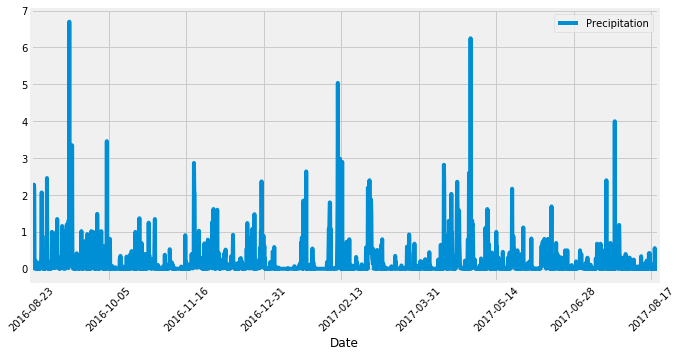

In [96]:
# Use Pandas Plotting with Matplotlib to plot the data
year_results_df.plot(y="Precipitation", figsize=(10,5), rot=45)


In [31]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_results_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [32]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_count = session.query(Measurement.station, func.count(Measurement.station)).\
                              group_by(Measurement.station).\
                              order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                                filter(Measurement.station == "USC00519281").all()
active_station

[(54.0, 85.0, 71.66378066378067)]

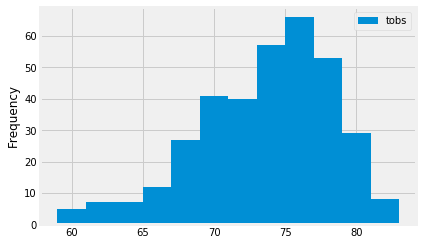

In [35]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obs_station = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= '2016-08-23')
temp_df = pd.DataFrame(temp_obs_station, columns=['tobs'])
temp_df.plot.hist(bins=12)


In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_temps = calc_temps('2017-07-01', '2017-07-16')
print(vacation_temps)

[(69.0, 78.25510204081633, 87.0)]


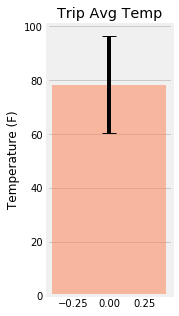

<Figure size 216x720 with 0 Axes>

In [81]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

peak = vacation_temps[0][2] - vacation_temps[0][0]

# figure size
plt.figure(figsize=[2,5])

# Define Bar and Error paramaters
plt.bar(0, vacation_temps[0][1], yerr = peak, color='coral', alpha=0.5, 
        ecolor='black', capsize=7)

# Labeling, tickers and grids
plt.ylabel('Temperature (F)')
plt.title('Trip Avg Temp')
plt.grid(axis='x')

# figure size
plt.figure(figsize=[3,10])

#Show the Plot
plt.show()


In [87]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

results = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.count(Measurement.prcp)).\
filter(Measurement.date >= '2017-07-01').\
filter(Measurement.date <= '2017-07-16').\
group_by(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
order_by(func.count(Measurement.prcp).desc()).all()

print(results)

[('USC00513117', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 16), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 16), ('USC00513117', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 16), ('USC00513117', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 16), ('USC00513117', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 16), ('USC00513117', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 16), ('USC00513117', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 16), ('USC00513117', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 16), ('USC00513117', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 16), ('USC00516128', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 16), ('USC00516128', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 16), ('USC00516128', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 16), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.

## Optional Challenge Assignment